In [ ]:
#FOR YOUR DATASET IF ITS IN ZIP
import zipfile
import os

def extract_zip(zip_file_path, extract_to_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_path)
extract_zip("/kaggle/working/predict.zip","predict_content")
extract_zip("/kaggle/working/train.zip","data_content")

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, ReLU, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.metrics import TopKCategoricalAccuracy


In [ ]:
# ==== CONFIGURATION ====
DATA_DIR = '/kaggle/working/data_content/Agumented '
TEST_DIR = '/kaggle/working/predict_content'
IMG_SIZE = (224, 224)
NUM_CLASSES = 16
EPOCHS = 50

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import os

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
DATA_DIR = '/kaggle/working/data_content/Agumented Data'

# ========== Augmentation Functions ==========

def preprocess(img, label):
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.keras.applications.resnet.preprocess_input(img)
    return img, label

def cutout(images, mask_size=50):
    def apply_cutout(img):
        h, w = img.shape[0], img.shape[1]
        y = tf.random.uniform([], 0, h, dtype=tf.int32)
        x = tf.random.uniform([], 0, w, dtype=tf.int32)
        y1 = tf.clip_by_value(y - mask_size // 2, 0, h)
        y2 = tf.clip_by_value(y + mask_size // 2, 0, h)
        x1 = tf.clip_by_value(x - mask_size // 2, 0, w)
        x2 = tf.clip_by_value(x + mask_size // 2, 0, w)
        cutout_mask = tf.ones((y2 - y1, x2 - x1), dtype=tf.float32)
        cutout_mask = tf.pad(cutout_mask, [[y1, h - y2], [x1, w - x2]])
        cutout_mask = tf.expand_dims(1. - cutout_mask, axis=-1)
        return img * cutout_mask
    return tf.map_fn(apply_cutout, images)

def mixup(images, labels, alpha=0.2):
    batch_size = tf.shape(images)[0]
    dist = tfp.distributions.Beta(alpha, alpha)
    lam = dist.sample([batch_size])
    lam = tf.maximum(lam, 1 - lam)

    index = tf.random.shuffle(tf.range(batch_size))
    mixed_images = lam[:, None, None, None] * images + (1 - lam)[:, None, None, None] * tf.gather(images, index)
    mixed_labels = lam[:, None] * labels + (1 - lam)[:, None] * tf.gather(labels, index)
    return mixed_images, mixed_labels

def cutmix(images, labels, alpha=1.0):
    batch_size = tf.shape(images)[0]
    indices = tf.random.shuffle(tf.range(batch_size))
    shuffled_images = tf.gather(images, indices)
    shuffled_labels = tf.gather(labels, indices)

    dist = tfp.distributions.Beta(alpha, alpha)
    lam = dist.sample()
    img_h, img_w = tf.shape(images)[1], tf.shape(images)[2]
    cut_rat = tf.math.sqrt(1. - lam)
    cut_w = tf.cast(img_w * cut_rat, tf.int32)
    cut_h = tf.cast(img_h * cut_rat, tf.int32)
    cx = tf.random.uniform([], 0, img_w, dtype=tf.int32)
    cy = tf.random.uniform([], 0, img_h, dtype=tf.int32)
    x1 = tf.clip_by_value(cx - cut_w // 2, 0, img_w)
    y1 = tf.clip_by_value(cy - cut_h // 2, 0, img_h)
    x2 = tf.clip_by_value(cx + cut_w // 2, 0, img_w)
    y2 = tf.clip_by_value(cy + cut_h // 2, 0, img_h)

    for i in range(batch_size):
        images = tf.tensor_scatter_nd_update(images, [[i]], [tf.tensor_scatter_nd_update(
            images[i],
            tf.stack(tf.meshgrid(tf.range(y1, y2), tf.range(x1, x2), indexing='ij'), axis=-1),
            shuffled_images[i, y1:y2, x1:x2]
        )])

    lam_adjusted = 1 - ((x2 - x1) * (y2 - y1)) / (img_w * img_h)
    labels = lam_adjusted * labels + (1 - lam_adjusted) * shuffled_labels
    return images, labels

# ========== Dataset Loader ==========

def load_dataset(data_dir, img_size=(224, 224), batch_size=32, augment=False, mix_type='none'):
    ds_train = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset='training',
        seed=42,
        label_mode='categorical',
        image_size=img_size,
        batch_size=batch_size
    )

    ds_val = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset='validation',
        seed=42,
        label_mode='categorical',
        image_size=img_size,
        batch_size=batch_size
    )

    class_names = ds_train.class_names
    class_to_idx = {class_name: i for i, class_name in enumerate(class_names)}

    ds_train = ds_train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds_val = ds_val.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

    if augment:
        ds_train = ds_train.map(lambda x, y: (tf.image.random_flip_left_right(x), y), num_parallel_calls=tf.data.AUTOTUNE)
        ds_train = ds_train.map(lambda x, y: (tf.image.random_brightness(x, 0.1), y), num_parallel_calls=tf.data.AUTOTUNE)
        ds_train = ds_train.map(lambda x, y: (cutout(x), y), num_parallel_calls=tf.data.AUTOTUNE)

        if mix_type == 'mixup':
            ds_train = ds_train.map(lambda x, y: mixup(x, y), num_parallel_calls=tf.data.AUTOTUNE)
        elif mix_type == 'cutmix':
            ds_train = ds_train.map(lambda x, y: cutmix(x, y), num_parallel_calls=tf.data.AUTOTUNE)

    train_loader = ds_train.prefetch(tf.data.AUTOTUNE)
    val_loader = ds_val.prefetch(tf.data.AUTOTUNE)
    return train_loader, val_loader, class_to_idx, class_names

In [ ]:
# Class mapping
train_loader, val_loader, class_to_idx, class_names = load_dataset(DATA_DIR, IMG_SIZE, BATCH_SIZE, augment=True, mix_type='mixup')

idx_to_class = {v: k for k, v in class_to_idx.items()}

# ==== Model Definition ====
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import TopKCategoricalAccuracy

# === Constants ===
IMG_SIZE = (224, 224, 3)
NUM_CLASSES = 16  # 15 known + 1 for -1 others

# === Load Pretrained Base Model ===
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=IMG_SIZE)

# === Freeze All Layers Except Last Block ===
for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers[-30:]:  # Fine-tune last ~30 layers
    layer.trainable = True

# === Custom Classification Head ===
inputs = Input(shape=IMG_SIZE)
x = base_model(inputs, training=True)  # Keep BN layers active
x = GlobalAveragePooling2D()(x)
x = Dense(256)(x)
x = ReLU()(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

# === Build and Compile Model ===
model = Model(inputs, outputs)
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', TopKCategoricalAccuracy(k=3, name='top_3_accuracy')]
)

model.summary()


Found 12654 files belonging to 16 classes.
Using 10124 files for training.
Found 12654 files belonging to 16 classes.
Using 2530 files for validation.


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_10 (ReLU)                      │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 16)                  │           4,112 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,117,392 (92.00 MB)

 Trainable params: 14,979,344 (57.14 MB)

 Non-trainable params: 9,138,048 (34.86 MB)

In [ ]:
from sklearn.metrics import f1_score
import numpy as np
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping

class F1CheckpointCallback(Callback):
    def __init__(self, val_data, save_path='best_model_f1.keras'):
        super().__init__()
        self.val_data = val_data
        self.best_f1 = 0.0
        self.save_path = save_path

    def on_epoch_end(self, epoch, logs=None):
        y_true = []
        y_pred = []

        for x_batch, y_batch in self.val_data:
            preds = self.model.predict(x_batch, verbose=0)
            y_true.extend(np.argmax(y_batch, axis=1))
            y_pred.extend(np.argmax(preds, axis=1))

        f1 = f1_score(y_true, y_pred, average='weighted')
        print(f"\nEpoch {epoch+1}: Validation F1 Score = {f1:.4f}")

        if f1 > self.best_f1:
            print(f"✅ F1 improved from {self.best_f1:.4f} to {f1:.4f}. Saving model to {self.save_path}")
            self.best_f1 = f1
            self.model.save(self.save_path)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os

# Count the number of images per class from folder names
classes = sorted(os.listdir(DATA_DIR))  # assumes 1 folder per class
class_counts = [len(os.listdir(os.path.join(DATA_DIR, cls))) for cls in classes]
class_indices = {cls: idx for idx, cls in enumerate(classes)}

# Flatten class labels for sklearn
y_labels = np.concatenate([[class_indices[cls]] * count for cls, count in zip(classes, class_counts)])

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_labels),
    y=y_labels
)

# Cap weight of known classes and raise the one for '-1'
class_weights = np.clip(class_weights, 0.25, 2.0)  # floor for -1, ceiling for others

# Final dictionary
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Optional: print class weights
for i, w in class_weight_dict.items():
    print(f"Class {i} ({classes[i]}): weight = {w:.2f}")


Class 0 (-1): weight = 0.25
Class 1 (0): weight = 1.62
Class 2 (1): weight = 1.67
Class 3 (10): weight = 1.47
Class 4 (11): weight = 1.65
Class 5 (12): weight = 1.55
Class 6 (13): weight = 1.43
Class 7 (14): weight = 1.45
Class 8 (2): weight = 1.76
Class 9 (3): weight = 1.50
Class 10 (4): weight = 1.65
Class 11 (5): weight = 1.98
Class 12 (6): weight = 1.82
Class 13 (7): weight = 1.55
Class 14 (8): weight = 1.63
Class 15 (9): weight = 1.79


In [ ]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1),
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    F1CheckpointCallback(val_data=val_loader, save_path='best_model_f1.keras')
]


In [ ]:
history=model.fit(
    train_loader,
    validation_data=val_loader,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)


Epoch 1/50
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.1358 - loss: 3.1139 - top_3_accuracy: 0.3085
Epoch 1: Validation F1 Score = 0.3669
✅ F1 improved from 0.0000 to 0.3669. Saving model to best_model_f1.keras
317/317 ━━━━━━━━━━━━━━━━━━━━ 87s 196ms/step - accuracy: 0.1360 - loss: 3.1129 - top_3_accuracy: 0.3087 - val_accuracy: 0.3680 - val_loss: 2.1220 - val_top_3_accuracy: 0.6253 - learning_rate: 1.0000e-04
Epoch 2/50
316/317 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3280 - loss: 2.1785 - top_3_accuracy: 0.5694
Epoch 2: Validation F1 Score = 0.4678
✅ F1 improved from 0.3669 to 0.4678. Saving model to best_model_f1.keras
317/317 ━━━━━━━━━━━━━━━━━━━━ 43s 134ms/step - accuracy: 0.3282 - loss: 2.1778 - top_3_accuracy: 0.5696 - val_accuracy: 0.4672 - val_loss: 1.8209 - val_top_3_accuracy: 0.7170 - learning_rate: 1.0000e-04
Epoch 3/50
316/317 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.4396 - loss: 1.7385 - top_3_accuracy: 0.6901
Epoch 3: Validation F1 Score = 0.5772


In [ ]:
# ==== Evaluation ====
y_true, y_pred, top3_correct = [], [], 0

for X_batch, y_batch in val_loader:
    y_true.extend(np.argmax(y_batch, axis=1))
    preds = model.predict(X_batch)
    y_pred.extend(np.argmax(preds, axis=1))

    top3 = np.argsort(preds, axis=1)[:, -3:]
    for j in range(len(y_batch)):
        if np.argmax(y_batch[j]) in top3[j]:
            top3_correct += 1

val_acc = accuracy_score(y_true, y_pred)
top3_acc = top3_correct / len(y_true)
f1 = f1_score(y_true, y_pred, average='weighted')
prec = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')

print(f"Final Eval - Top-1 Acc: {val_acc:.4f} | Top-3 Acc: {top3_acc:.4f} | F1: {f1:.4f} | Prec: {prec:.4f} | Recall: {recall:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━

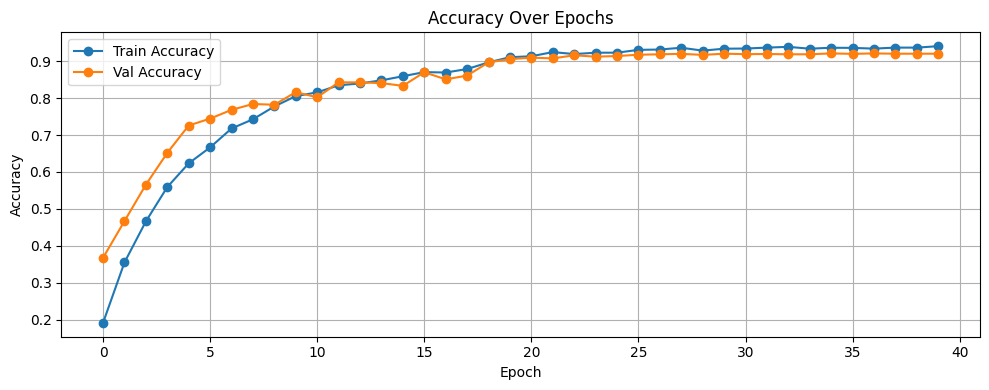

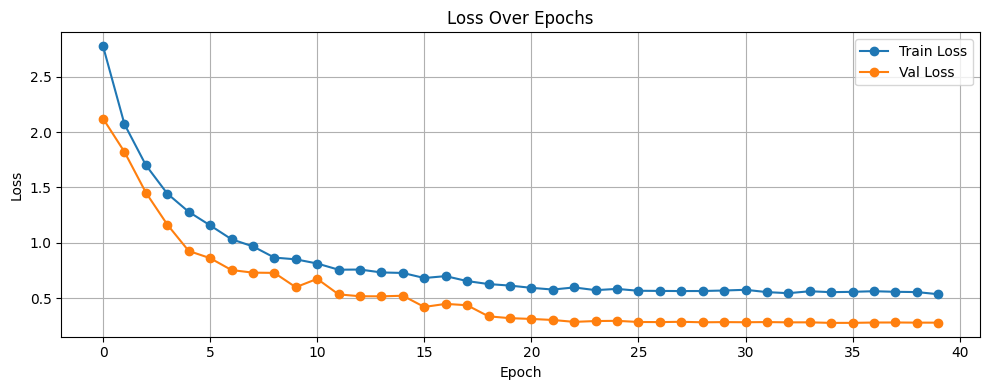

In [ ]:
import matplotlib.pyplot as plt
# === Accuracy Plot ===
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Loss Plot ===
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np


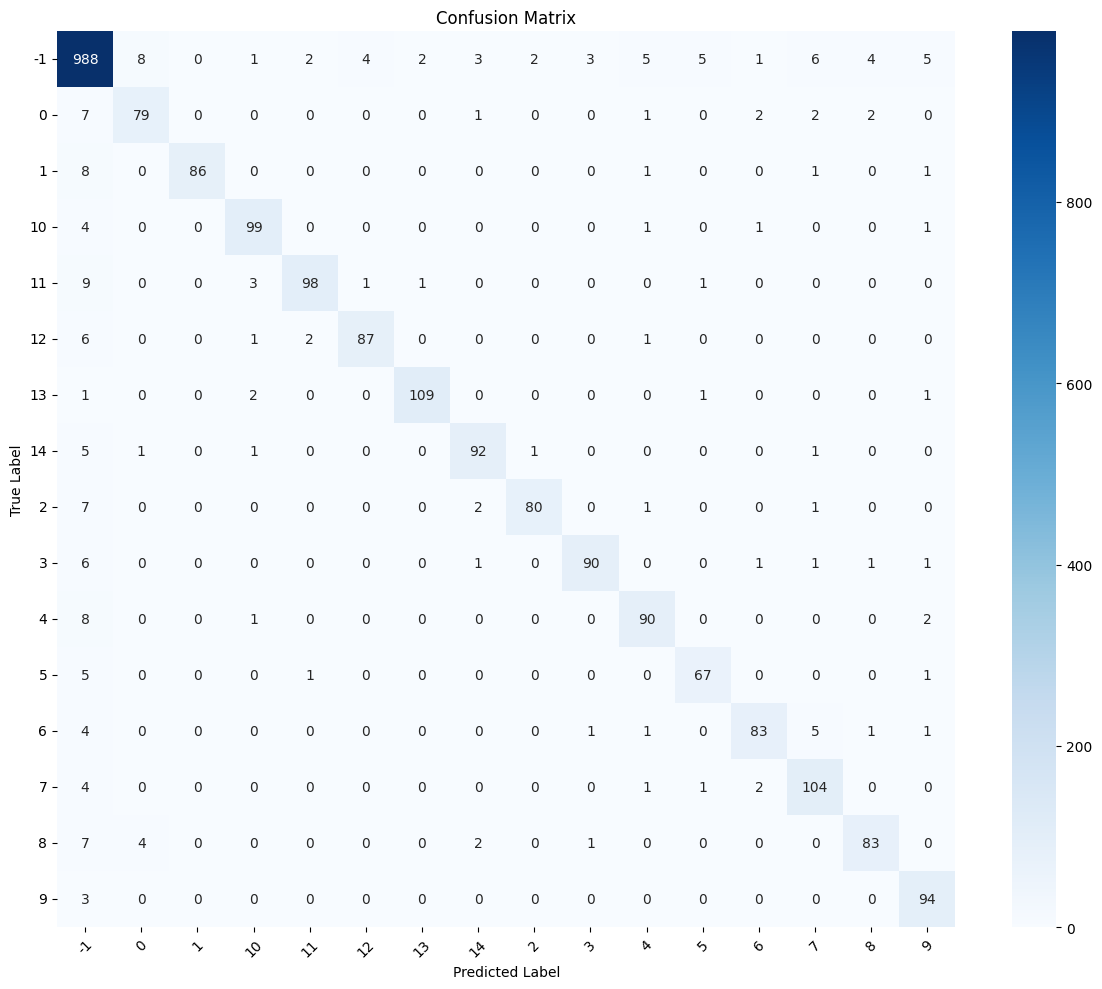

<Figure size 1200x600 with 0 Axes>

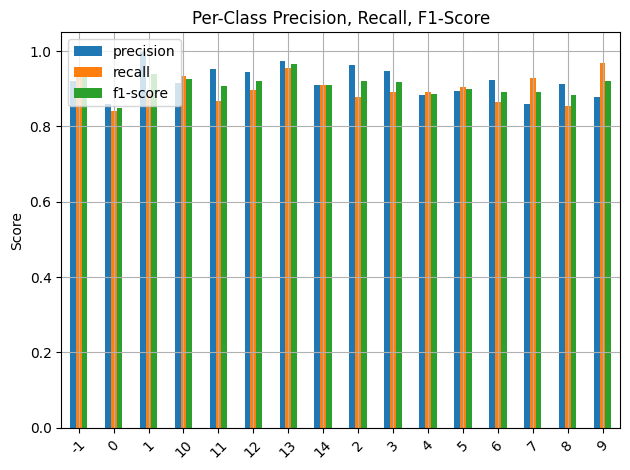

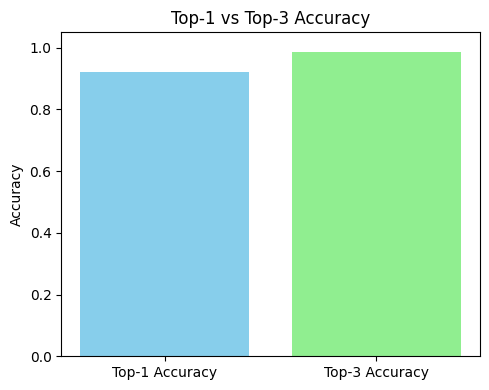

In [ ]:
# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# === Classification Report as DataFrame ===
report_dict = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# === Bar Plot: Precision, Recall, F1 per Class ===
plt.figure(figsize=(12, 6))
report_df.iloc[:-3][['precision', 'recall', 'f1-score']].plot(kind='bar')
plt.title('Per-Class Precision, Recall, F1-Score')
plt.ylabel('Score')
plt.ylim(0, 1.05)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# === Top-1 vs Top-3 Accuracy Summary Bar ===
plt.figure(figsize=(5, 4))
plt.bar(['Top-1 Accuracy', 'Top-3 Accuracy'], [val_acc, top3_acc], color=['skyblue', 'lightgreen'])
plt.ylim(0, 1.05)
plt.ylabel('Accuracy')
plt.title('Top-1 vs Top-3 Accuracy')
plt.tight_layout()
plt.show()

In [ ]:
# ==== Submission Prediction ====
model = load_model("/kaggle/working/best_model_f1.keras", custom_objects={'TopKCategoricalAccuracy': TopKCategoricalAccuracy})

submission_files = sorted([f for f in os.listdir(TEST_DIR) if f.lower().endswith(('jpg', 'jpeg', 'png'))])

filenames, mapped_labels = [], []
for fname in tqdm(submission_files):
    img = load_img(os.path.join(TEST_DIR, fname), target_size=(224, 224))
    x = img_to_array(img)
    x = preprocess_input(x)
    x = np.expand_dims(x, axis=0)

    pred = model.predict(x)
    label_idx = np.argmax(pred)
    label = idx_to_class[label_idx]

    filenames.append(fname)
    mapped_labels.append(label)

submission_df = pd.DataFrame({'Id': filenames, 'label': mapped_labels})
submission_df.to_csv("new_submission.csv", index=False)
print("✅ Saved submission.csv with", len(submission_df), "rows")


  0%|          | 0/425 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


  0%|          | 1/425 [00:04<32:51,  4.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  1%|          | 3/425 [00:04<08:55,  1.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  1%|          | 5/425 [00:04<04:36,  1.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  2%|▏         | 7/425 [00:05<02:53,  2.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  2%|▏         | 9/425 [00:05<02:00,  3.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  3%|▎         | 11/425 [00:05<01:29,  4.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  3%|▎         | 13/425 [00:05<01:10,  5.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  4%|▎         | 15/425 [00:05<00:58,  7.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  4%|▍         | 17/425 [00:05<00:49,  8.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  4%|▍         | 19/425 [00:06<00:45,  8.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▍         | 21/425 [00:06<00:42,  9.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  5%|▌         | 23/425 [00:06<00:39, 10.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  6%|▌         | 25/425 [00:06<00:37, 10.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  6%|▋         | 27/425 [00:06<00:35, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  7%|▋         | 29/425 [00:06<00:34, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  7%|▋         | 31/425 [00:07<00:33, 11.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  8%|▊         | 33/425 [00:07<00:32, 11.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  8%|▊         | 35/425 [00:07<00:32, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  9%|▊         | 37/425 [00:07<00:31, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  9%|▉         | 39/425 [00:07<00:31, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 10%|▉         | 41/425 [00:07<00:30, 12.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 10%|█         | 43/425 [00:08<00:30, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 11%|█         | 45/425 [00:08<00:31, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 11%|█         | 47/425 [00:08<00:31, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 12%|█▏        | 49/425 [00:08<00:30, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 12%|█▏        | 51/425 [00:08<00:30, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 12%|█▏        | 53/425 [00:08<00:30, 12.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 13%|█▎        | 55/425 [00:09<00:29, 12.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 13%|█▎        | 57/425 [00:09<00:29, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 14%|█▍        | 59/425 [00:09<00:29, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 14%|█▍        | 61/425 [00:09<00:29, 12.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 15%|█▍        | 63/425 [00:09<00:29, 12.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 15%|█▌        | 65/425 [00:09<00:28, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 16%|█▌        | 67/425 [00:10<00:29, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 16%|█▌        | 69/425 [00:10<00:29, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 17%|█▋        | 71/425 [00:10<00:28, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 17%|█▋        | 73/425 [00:10<00:28, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 18%|█▊        | 75/425 [00:10<00:28, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 18%|█▊        | 77/425 [00:10<00:28, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 19%|█▊        | 79/425 [00:11<00:28, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 19%|█▉        | 81/425 [00:11<00:28, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 20%|█▉        | 83/425 [00:11<00:28, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 20%|██        | 85/425 [00:11<00:28, 11.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 20%|██        | 87/425 [00:11<00:28, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 21%|██        | 89/425 [00:11<00:29, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 21%|██▏       | 91/425 [00:12<00:29, 11.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 22%|██▏       | 93/425 [00:12<00:29, 11.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 22%|██▏       | 95/425 [00:12<00:30, 10.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 23%|██▎       | 97/425 [00:12<00:29, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 23%|██▎       | 99/425 [00:12<00:29, 11.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 24%|██▍       | 101/425 [00:12<00:28, 11.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 24%|██▍       | 103/425 [00:13<00:28, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 25%|██▍       | 105/425 [00:13<00:27, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 25%|██▌       | 107/425 [00:13<00:26, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 26%|██▌       | 109/425 [00:13<00:26, 12.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 26%|██▌       | 111/425 [00:13<00:25, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 27%|██▋       | 113/425 [00:13<00:25, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 27%|██▋       | 115/425 [00:14<00:24, 12.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 28%|██▊       | 117/425 [00:14<00:24, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 28%|██▊       | 119/425 [00:14<00:24, 12.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 121/425 [00:14<00:24, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 29%|██▉       | 123/425 [00:14<00:24, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 29%|██▉       | 125/425 [00:14<00:24, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 30%|██▉       | 127/425 [00:15<00:24, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 30%|███       | 129/425 [00:15<00:24, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 31%|███       | 131/425 [00:15<00:24, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 31%|███▏      | 133/425 [00:15<00:23, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 32%|███▏      | 135/425 [00:15<00:23, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 32%|███▏      | 137/425 [00:15<00:23, 12.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 33%|███▎      | 139/425 [00:16<00:23, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 33%|███▎      | 141/425 [00:16<00:23, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 34%|███▎      | 143/425 [00:16<00:22, 12.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 34%|███▍      | 145/425 [00:16<00:22, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 35%|███▍      | 147/425 [00:16<00:22, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 35%|███▌      | 149/425 [00:16<00:22, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 36%|███▌      | 151/425 [00:17<00:22, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 36%|███▌      | 153/425 [00:17<00:22, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 36%|███▋      | 155/425 [00:17<00:22, 12.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 37%|███▋      | 157/425 [00:17<00:22, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 37%|███▋      | 159/425 [00:17<00:21, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 38%|███▊      | 161/425 [00:17<00:21, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 38%|███▊      | 163/425 [00:18<00:21, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 39%|███▉      | 165/425 [00:18<00:21, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 39%|███▉      | 167/425 [00:18<00:21, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 40%|███▉      | 169/425 [00:18<00:21, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 40%|████      | 171/425 [00:18<00:20, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 41%|████      | 173/425 [00:18<00:20, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 41%|████      | 175/425 [00:19<00:20, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 42%|████▏     | 177/425 [00:19<00:20, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 42%|████▏     | 179/425 [00:19<00:20, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 43%|████▎     | 181/425 [00:19<00:19, 12.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 43%|████▎     | 183/425 [00:19<00:19, 12.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 44%|████▎     | 185/425 [00:19<00:19, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 44%|████▍     | 187/425 [00:19<00:19, 12.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 44%|████▍     | 189/425 [00:20<00:19, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 45%|████▍     | 191/425 [00:20<00:19, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 45%|████▌     | 193/425 [00:20<00:18, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 46%|████▌     | 195/425 [00:20<00:18, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 46%|████▋     | 197/425 [00:20<00:18, 12.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 47%|████▋     | 199/425 [00:20<00:18, 12.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 47%|████▋     | 201/425 [00:21<00:18, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 48%|████▊     | 203/425 [00:21<00:18, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 48%|████▊     | 205/425 [00:21<00:17, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 49%|████▊     | 207/425 [00:21<00:17, 12.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 49%|████▉     | 209/425 [00:21<00:17, 12.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 50%|████▉     | 211/425 [00:21<00:17, 12.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 50%|█████     | 213/425 [00:22<00:17, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 51%|█████     | 215/425 [00:22<00:17, 11.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 51%|█████     | 217/425 [00:22<00:18, 11.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 52%|█████▏    | 219/425 [00:22<00:17, 11.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 52%|█████▏    | 221/425 [00:22<00:17, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 52%|█████▏    | 223/425 [00:22<00:16, 12.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 53%|█████▎    | 225/425 [00:23<00:16, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 53%|█████▎    | 227/425 [00:23<00:16, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 54%|█████▍    | 229/425 [00:23<00:16, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 54%|█████▍    | 231/425 [00:23<00:16, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 55%|█████▍    | 233/425 [00:23<00:16, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 55%|█████▌    | 235/425 [00:23<00:15, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 56%|█████▌    | 237/425 [00:24<00:15, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 56%|█████▌    | 239/425 [00:24<00:15, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 57%|█████▋    | 241/425 [00:24<00:15, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 57%|█████▋    | 243/425 [00:24<00:15, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 58%|█████▊    | 245/425 [00:24<00:14, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 58%|█████▊    | 247/425 [00:24<00:14, 12.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 59%|█████▊    | 249/425 [00:25<00:14, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 59%|█████▉    | 251/425 [00:25<00:14, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 60%|█████▉    | 253/425 [00:25<00:14, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 60%|██████    | 255/425 [00:25<00:13, 12.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 60%|██████    | 257/425 [00:25<00:13, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 61%|██████    | 259/425 [00:25<00:13, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████▏   | 261/425 [00:26<00:13, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 62%|██████▏   | 263/425 [00:26<00:13, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 62%|██████▏   | 265/425 [00:26<00:13, 12.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 63%|██████▎   | 267/425 [00:26<00:12, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 63%|██████▎   | 269/425 [00:26<00:12, 12.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 64%|██████▍   | 271/425 [00:26<00:12, 12.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 64%|██████▍   | 273/425 [00:27<00:12, 12.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 65%|██████▍   | 275/425 [00:27<00:11, 12.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 65%|██████▌   | 277/425 [00:27<00:11, 12.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 66%|██████▌   | 279/425 [00:27<00:11, 12.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 66%|██████▌   | 281/425 [00:27<00:11, 12.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 67%|██████▋   | 283/425 [00:27<00:11, 12.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 67%|██████▋   | 285/425 [00:27<00:11, 12.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 68%|██████▊   | 287/425 [00:28<00:10, 12.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 68%|██████▊   | 289/425 [00:28<00:10, 12.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 68%|██████▊   | 291/425 [00:28<00:10, 12.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 69%|██████▉   | 293/425 [00:28<00:10, 12.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 69%|██████▉   | 295/425 [00:28<00:10, 12.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 70%|██████▉   | 297/425 [00:28<00:10, 12.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 70%|███████   | 299/425 [00:29<00:10, 12.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 71%|███████   | 301/425 [00:29<00:09, 12.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 71%|███████▏  | 303/425 [00:29<00:09, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 72%|███████▏  | 305/425 [00:29<00:09, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 72%|███████▏  | 307/425 [00:29<00:09, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 73%|███████▎  | 309/425 [00:29<00:09, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 73%|███████▎  | 311/425 [00:30<00:09, 12.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 74%|███████▎  | 313/425 [00:30<00:09, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 74%|███████▍  | 315/425 [00:30<00:08, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 75%|███████▍  | 317/425 [00:30<00:08, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 75%|███████▌  | 319/425 [00:30<00:08, 12.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 76%|███████▌  | 321/425 [00:30<00:08, 12.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 76%|███████▌  | 323/425 [00:31<00:08, 12.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 76%|███████▋  | 325/425 [00:31<00:08, 12.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 77%|███████▋  | 327/425 [00:31<00:07, 12.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 77%|███████▋  | 329/425 [00:31<00:07, 12.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 78%|███████▊  | 331/425 [00:31<00:07, 12.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 78%|███████▊  | 333/425 [00:31<00:07, 12.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 79%|███████▉  | 335/425 [00:32<00:07, 12.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 79%|███████▉  | 337/425 [00:32<00:07, 12.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 80%|███████▉  | 339/425 [00:32<00:07, 11.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 80%|████████  | 341/425 [00:32<00:07, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 81%|████████  | 343/425 [00:32<00:06, 11.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 81%|████████  | 345/425 [00:32<00:07, 11.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 82%|████████▏ | 347/425 [00:33<00:07, 10.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 82%|████████▏ | 349/425 [00:33<00:06, 10.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 83%|████████▎ | 351/425 [00:33<00:06, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 83%|████████▎ | 353/425 [00:33<00:06, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 84%|████████▎ | 355/425 [00:33<00:06, 11.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 84%|████████▍ | 357/425 [00:33<00:06, 11.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 84%|████████▍ | 359/425 [00:34<00:05, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 85%|████████▍ | 361/425 [00:34<00:05, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 85%|████████▌ | 363/425 [00:34<00:05, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 86%|████████▌ | 365/425 [00:34<00:04, 12.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 86%|████████▋ | 367/425 [00:34<00:04, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 87%|████████▋ | 369/425 [00:34<00:04, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 87%|████████▋ | 371/425 [00:35<00:04, 12.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 88%|████████▊ | 373/425 [00:35<00:04, 12.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 88%|████████▊ | 375/425 [00:35<00:04, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 89%|████████▊ | 377/425 [00:35<00:03, 12.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 89%|████████▉ | 379/425 [00:35<00:03, 12.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 90%|████████▉ | 381/425 [00:35<00:03, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 90%|█████████ | 383/425 [00:36<00:03, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 91%|█████████ | 385/425 [00:36<00:03, 12.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 91%|█████████ | 387/425 [00:36<00:03, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 92%|█████████▏| 389/425 [00:36<00:02, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 92%|█████████▏| 391/425 [00:36<00:02, 12.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 92%|█████████▏| 393/425 [00:36<00:02, 12.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 93%|█████████▎| 395/425 [00:37<00:02, 12.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 93%|█████████▎| 397/425 [00:37<00:02, 12.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 94%|█████████▍| 399/425 [00:37<00:02, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 94%|█████████▍| 401/425 [00:37<00:02, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 95%|█████████▍| 403/425 [00:37<00:01, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 95%|█████████▌| 405/425 [00:37<00:01, 11.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 96%|█████████▌| 407/425 [00:38<00:01, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 96%|█████████▌| 409/425 [00:38<00:01, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 97%|█████████▋| 411/425 [00:38<00:01, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 97%|█████████▋| 413/425 [00:38<00:00, 12.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 98%|█████████▊| 415/425 [00:38<00:00, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 98%|█████████▊| 417/425 [00:38<00:00, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 99%|█████████▊| 419/425 [00:39<00:00, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 99%|█████████▉| 421/425 [00:39<00:00, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


100%|█████████▉| 423/425 [00:39<00:00, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


100%|██████████| 425/425 [00:39<00:00, 10.76it/s]

✅ Saved submission.csv with 425 rows
